In [1]:
# Task 1
# Imports
from pgmpy.factors.discrete import TabularCPD
import numpy as np
import pandas as pd
from pgmpy.models import BayesianModel
import network_map
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import K2Score
from pgmpy.inference import VariableElimination
import pandas as pd

In [2]:
edges_list = network_map.edges_list
nodes_list = network_map.nodes_list
cpds_list = network_map.cpds_list
marginal_list = network_map.marginal_list

In [52]:
# Functions
def independence_test(condVar,varY,stateX,stateY,cpd_val,marginal_list):
    stateY = int(stateY)
    stateX = int(stateX)
    prob_Y_given_X = cpd_val[stateY][stateX]
    marginal_X = marginal_list[condVar][stateX]
    lhs = np.multiply(prob_Y_given_X,marginal_X)
    marginal_Y = marginal_list[varY][stateY]
    rhs = np.multiply(marginal_Y,marginal_X)
    return (np.abs(lhs-rhs))

def accio_cpd_table(_cond_var):
    '''
    Lookup the CPD table for a given Variable
    Returns the table in which the dist is encoded in
    '''
    switch_cpd_dict_given = {'x1':0,'x2':1,'x3':2,'x4':3,'x5':4,'x6':5}
    table = switch_cpd_dict_given[_cond_var]
    return table

def accio_state_table(_var,nodes_list):
    switch_node_dict = {'x1':0,'x2':0,'x3':1,'x4':0,'x5':1,'x6':2}
    states_possible = switch_node_dict[_var]
    states_possible = len(list(nodes_list[switch_node_dict[_var]][_var].values())[0].keys())
    return states_possible

def find_cpd_defined_or_not(varA,givenVar):
    for _cpds in cpds_list[accio_cpd_table(givenVar)]:
        if varA in _cpds["Variables"].keys():
            return "D"
    for _cpds in cpds_list[accio_cpd_table(varA)]:
        if givenVar in _cpds["Variables"].keys():
            return "B"
    return "I"

def find_given(_varA,_cond_var,_cond_var_state,_varA_state,cpds_list,marginal_list,ind_dict):
    '''
    Finds if a variable is dependent or not on the assumption in the paper that any variables
    not present in the cpd tables are independent
    '''
    # Find given values
    _cpds = cpds_list[accio_cpd_table(_cond_var)]
    if(ind_dict[_varA] == 'I'):
        #print("Marg")
        # Discarding Cond Var and marg lookup
        return marginal_list[_varA][_varA_state]
    elif(ind_dict[_varA] == 'B'):
        # Bayes theorem
        for _cpd in cpds_list[accio_cpd_table(_varA)]:
            if _cond_var in _cpd["Variables"]:
                #print(_cpd)
                left = _cpd["Values"][_cond_var_state][_varA_state]
        #print(_varA,_cond_var)
        right = marginal_list[_varA][_varA_state]
        #print(left,",",right)
        num = np.multiply(left,right)
        deno = marginal_list[_cond_var][_cond_var_state]
        #print(np.divide(num,deno))
        return np.divide(num,deno)
    elif(ind_dict[_varA] == 'D'):
        #print("Cond Lookup")
        for _cpd in _cpds:
            if _varA in _cpd["Variables"]:
                return _cpd["Values"][_varA_state][_cond_var_state]
            
def v_structure_cpd(cond_var,random_var):
    # Need recursion for future to decompose multiple nodes
    '''
    Toy example:
    We have P(Y | X1,X2)
    1. Finding Conditionals: P(X1 | Y), P(X2 | Y), P(X1 | X2)
    2. Finding Marginals: P(Y), P(X2)
    Finding 60 variables
    '''

    # How to find which table corresponds to the rand var? See the function desc for more details
    table = accio_cpd_table(random_var)

    # Finding the states of the rand var and cond var
    switch_node_dict = {'x1':0,'x2':0,'x3':1,'x4':0,'x5':1,'x6':2}
    _state_dict = {}
    _random_var_states = len(list(nodes_list[switch_node_dict[random_var]][random_var].values())[0].keys())
    for _cond_var in cond_var:
        _state_dict[_cond_var] = len(list(nodes_list[switch_node_dict[_cond_var]][_cond_var].values())[0].keys())

    # Independent dict to keep track of the variables which are dependent on the paper assumption
    ind_dict = {}
    for _cond_var in cond_var:
        ind_dict[_cond_var] = find_cpd_defined_or_not(_cond_var,random_var)
    # Skeleton of the resulting CPD
    x2_given_x1_x3_cpd = [[] for i in range(_random_var_states)]
    #print(_random_var_states)
    #print(_state_dict)
    i = 0  # Diags
    for Y_state in range(_random_var_states):
        for X2_state in range(_state_dict[cond_var[1]]):
            for X1_state in range(_state_dict[cond_var[0]]):
                i +=1  # Diags
                X1_given_Y = find_given(_varA=cond_var[0],_cond_var=random_var,
                                 _varA_state=X1_state,_cond_var_state=Y_state,
                                 cpds_list=cpds_list,marginal_list=marginal_list,ind_dict=ind_dict)
                X2_given_Y = find_given(_varA=cond_var[1],_cond_var=random_var,
                                       _varA_state=X2_state,_cond_var_state=Y_state,
                                       cpds_list=cpds_list,marginal_list=marginal_list,ind_dict=ind_dict)
                Y = marginal_list[random_var][Y_state]
                '''
                Depends on the case if x1 and x2 are independent then use P(x).P(y) = P(x,y) or else have to use 
                P(x,y) = P(x | y). P(y)'''
                # Redifine
                if(find_cpd_defined_or_not(cond_var[0],cond_var[1]) == 'I'):
                    X1_X2 = np.multiply(marginal_list[cond_var[0]][X1_state],marginal_list[cond_var[1]][X2_state])
                else:
                    #print(find_cpd_defined_or_not(cond_var[0],cond_var[1]))
                    ind_dict2={cond_var[0]:find_cpd_defined_or_not(cond_var[0],cond_var[1])}
                    X1_X2 = find_given(_varA=cond_var[0],_cond_var=cond_var[1],
                                 _varA_state=X1_state,_cond_var_state=X2_state,
                                 cpds_list=cpds_list,marginal_list=marginal_list,ind_dict=ind_dict2)
                    #print(X1_X2)
                num = np.multiply(X1_given_Y,X2_given_Y)
                num = np.multiply(num,Y)
                deno = X1_X2
                x2_given_x1_x3_cpd[Y_state].append(np.divide(num,deno))
    cpd = TabularCPD(random_var,_random_var_states, np.array(x2_given_x1_x3_cpd),[cond_var[1],cond_var[0]], [_state_dict[cond_var[1]],_state_dict[cond_var[0]]])
    if(not cpd.is_valid_cpd()):
        cpd.normalize(inplace=True)
    cpd = TabularCPD(random_var,_random_var_states, np.array(np.round(cpd.get_values(),4)), [cond_var[1],cond_var[0]], [_state_dict[cond_var[1]],_state_dict[cond_var[0]]])
    return cpd

In [14]:
# x6,x5 tables wrong
numTables = 6
for table in range(numTables):
    _edges = edges_list[table]
    _nodes = nodes_list[table]
    _cpds = cpds_list[table]
    for cpd in _cpds:
        varY = list(cpd["Variables"].keys())[0]
        condVar = list(cpd["Variables"].values())[0][0]
        cpd_val = cpd['Values']
        print(varY,",",condVar)
        lOne = []
        for stateY in _nodes[varY]['States'].keys():
            for stateX in _nodes[condVar]['States'].keys():
                lOne.append(independence_test(condVar,varY,stateX,stateY,cpd_val,marginal_list))
        print(np.sum(lOne))

x2 , x1
0.15977000000000002
x4 , x1
0.11943000000000005
x6 , x1
0.16015500000000005
x3 , x2
0.21852500000000008
x5 , x2
0.13246000000000005
x2 , x3
0.21875800000000004
x5 , x3
0.11551999999999997
x6 , x3
0.11324000000000001
x1 , x4
0.11957000000000005
x2 , x4
0.11569999999999997
x6 , x4
0.14347
x2 , x5
0.12939
x3 , x5
0.11596500000000003
x1 , x6
0.16036999999999998
x2 , x6
0.17531500000000003
x3 , x6
0.09434000000000006
x4 , x6
0.14306999999999997


In [ ]:
# Getting compound cpds
cond_var = ['x1','x3']
random_var = 'x2'
x2_given_x1_x3_cpd = v_structure_cpd(cond_var,random_var)
x2_given_x1_x3_cpd = np.array(x2_given_x1_x3_cpd)
for num in range(np.shape(x2_given_x1_x3_cpd)[1]):
    print(np.sum(x2_given_x1_x3_cpd[:,num]))

In [49]:
x2_given_x1_x3_cpd = np.array(x2_given_x1_x3_cpd)
x2_given_x1_x3_cpd

NameError: name 'x2_given_x1_x3_cpd' is not defined

# Network 1

In [80]:
x2_given_x5_x6= v_structure_cpd(['x5','x6'],'x2')

edges_list_nw = [
    [('x5','x2'),
    ('x3','x5'),
    ('x6','x2'),
    ('x6','x1'),
    ('x6','x4')]
]

cpds_list_nw = [
    [
        {
        'Values': cpds_list[accio_cpd_table('x3')][1]['Values'],
        'Variables':{'x5':['x3']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x6')][0]['Values'],
        'Variables':{'x1':['x6']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x6')][3]['Values'],
        'Variables':{'x4':['x6']}
        },
        {
        'Values': x2_given_x5_x6.get_values(),
        'Variables': {'x2':['x5','x6']}
        },
        {
        'Values': np.array(marginal_list['x3']),
        'Variables':{'x3':[]}
        },
                {
        'Values': np.array(marginal_list['x6']),
        'Variables':{'x6':[]}
        }
    ]
]


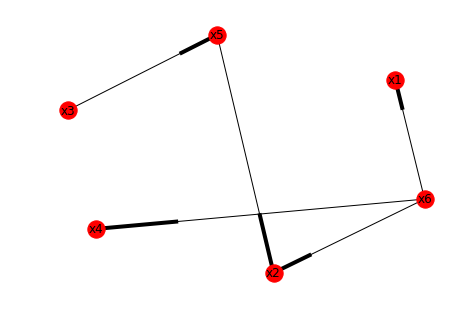

In [102]:
'''
NW1
'''
table = 0
_edges = edges_list_nw[table]
_nodes = nodes_list[table]
_cpds = cpds_list_nw[table]
nw1 = BayesianModel(_edges)

for node in _nodes:
    #model.node[node] = nodes[node]
    nw1.node[node].update(_nodes[node])

tabular_cpds = []
# V Structure
tabular_cpds.append(TabularCPD('x2',accio_state_table('x2',nodes_list),cpds_list_nw[0][3]['Values'],['x6','x5'],[accio_state_table('x6',nodes_list),accio_state_table('x5',nodes_list)]))
# Marginals
tabular_cpds.append(TabularCPD('x6',accio_state_table('x6',nodes_list),[cpds_list_nw[0][5]['Values']]))
tabular_cpds.append(TabularCPD('x3',accio_state_table('x3',nodes_list),[cpds_list_nw[0][4]['Values']]))
# Directed Links
tabular_cpds.append(TabularCPD('x5',accio_state_table('x5',nodes_list),cpds_list_nw[0][0]['Values'],['x3'],[accio_state_table('x3',nodes_list)]))
tabular_cpds.append(TabularCPD('x1',accio_state_table('x1',nodes_list),cpds_list_nw[0][1]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))
tabular_cpds.append(TabularCPD('x4',accio_state_table('x4',nodes_list),cpds_list_nw[0][2]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))

nw1.add_cpds(*tabular_cpds)

#for cpd in nw1.cpds:
    #print(cpd)

# Requires matplotlib < 2.2
import networkx as nx
import pylab as plt
nx.draw(nw1, with_labels=True)
plt.show()

In [145]:
inference1 = BayesianModelSampling(nw1)

dataNw1 = inference1.forward_sample(size=50000, return_type='dataframe')

k2Nw1 = K2Score(dataNw1)

In [146]:
k2Nw1.score(nw1)

-314166.6447737128

# Network 2

In [105]:
cpds_list[accio_cpd_table('x6')][2]['Values']

array([[0.   , 0.218, 0.107, 0.206, 0.143],
       [1.   , 0.656, 0.714, 0.635, 0.643],
       [0.   , 0.125, 0.179, 0.159, 0.214]])

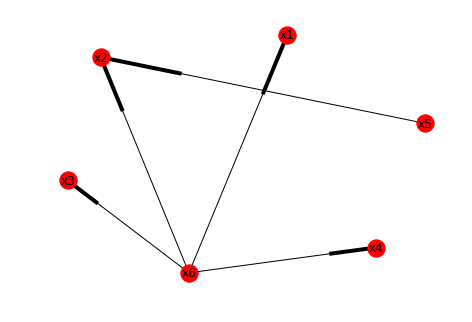

In [142]:
x2_given_x5_x6= v_structure_cpd(['x5','x6'],'x2')

edges_list_nw = [
    [('x5','x2'),
     ('x6','x2'),
     ('x6','x3'),
     ('x6','x4'),
     ('x6','x1'),
    ]
]

cpds_list_nw = [
    [
        {
        'Values': cpds_list[accio_cpd_table('x6')][2]['Values'],
        'Variables':{'x3':['x6']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x6')][0]['Values'],
        'Variables':{'x1':['x6']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x6')][3]['Values'],
        'Variables':{'x4':['x6']}
        },
        {
        'Values': x2_given_x5_x6.get_values(),
        'Variables': {'x2':['x5','x6']}
        },
        {
        'Values': np.array(marginal_list['x5']),
        'Variables':{'x5':[]}
        },
                {
        'Values': np.array(marginal_list['x6']),
        'Variables':{'x6':[]}
        }
    ]
]


'''
NW1
'''
table = 0
_edges = edges_list_nw[table]
_nodes = nodes_list[table]
_cpds = cpds_list_nw[table]
nw2 = BayesianModel(_edges)

for node in _nodes:
    #model.node[node] = nodes[node]
    nw2.node[node].update(_nodes[node])

tabular_cpds = []
# V Structure
tabular_cpds.append(TabularCPD('x2',accio_state_table('x2',nodes_list),cpds_list_nw[0][3]['Values'],['x6','x5'],[accio_state_table('x6',nodes_list),accio_state_table('x5',nodes_list)]))
# Marginals
tabular_cpds.append(TabularCPD('x6',accio_state_table('x6',nodes_list),[cpds_list_nw[0][5]['Values']]))
tabular_cpds.append(TabularCPD('x5',accio_state_table('x5',nodes_list),[cpds_list_nw[0][4]['Values']]))
# Directed Links
tabular_cpds.append(TabularCPD('x3',accio_state_table('x3',nodes_list),cpds_list_nw[0][0]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))
tabular_cpds.append(TabularCPD('x1',accio_state_table('x1',nodes_list),cpds_list_nw[0][1]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))
tabular_cpds.append(TabularCPD('x4',accio_state_table('x4',nodes_list),cpds_list_nw[0][2]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))

nw2.add_cpds(*tabular_cpds)

#for cpd in nw1.cpds:
    #print(cpd)

# Requires matplotlib < 2.2
import networkx as nx
import pylab as plt
nx.draw(nw1, with_labels=True)
plt.show()

In [143]:
inference2 = BayesianModelSampling(nw2)

dataNw2 = inference2.forward_sample(size=50000, return_type='dataframe')

k2Nw2 = K2Score(dataNw2)

In [148]:
k2Nw2.score(nw2)

-314200.3436394362

In [149]:
k2Nw1.score(nw1)

-314166.6447737128